![logo](./img/LogoLine_horizon_C3S.png)

# Monthly mean tropospheric humidity data from satellite-based Radio Occultation measurements

### About

In this tutorial we will work with gridded monthly-mean tropospheric humidity data from the Climate Data Store (CDS). The aim is to demonstrate how to access the data and examine it to gain insights into the available physical variables and data structures. Additionally, we will explore a few **_use cases_** to showcase practical applications and processing techniques. These use cases involve plotting, providing an opportunity to deepen your understanding of humidity data and how it can be visualized.

The tutorial includes the following:

1. Background
2. Initial setup
3. Search, download, and inspect data
4. Work with data\
  4.1 Use case 1: Global latitude-height distribution of tropospheric humidity\
  4.2 Use case 2: Climate normal and anomalies\
  4.3 Use case 3: Seasonal variations of tropospheric humidity\
  4.4 Use case 4: Global humidity and the El Niño Southern Oscillation
5. References

## 1. Background

Atmospheric humidity plays an important role in the Earth's climate system, both for its strong greenhouse effect but also for its role in the global energy transport. Tropospheric humidity is central to the hydrological cycle and the formation of clouds, and sets the fundamental conditions for the biosphere, including distribution of rainfall and droughts.


#### Monitoring humidity from space

Humidity is difficult to measure accurately on a global scale. It can be highly variable and is often rapidly changing on short time scales and over short distances. Local measurements at weather stations or from weather balloons are rarely representative for a larger region of the atmosphere, and are too sparse to provide a truly global view. Global monitoring of atmospheric humidity requires observations from space. Such a space-based humidity data record is now available in the Climate Data Store, originating from the Radio Occultation (RO) data processed and archived at EUMETSAT's ROM SAF facility. The data are based on tracking GPS radio signals passing through the atmosphere. An advantage with this technique is that it is not affected by the presence of clouds or whether it is above land or ocean – the observations have a truly global distribution.


#### Data description

The gridded monthly-mean tropospheric humidity dataset is derived from a large number of observed humidity profiles retrieved from satellite-based RO measurements. It comprises a time series of continuous monthly humidity observations, starting in late 2006 and is extended up to present on regular basis intervals. As the dataset encompasses the entire globe, from the surface up to an altitude of 12 kilometers, and has high vertical resolution revealing fine scale details of the variations with height, it is well suited for analysis of the latitudinal and height distributions of humidity.

As shown in Section 3, the data consists of monthly variables on a latitude-height grid. The data records are stored in netCDF files, which is a common format for array-oriented scientific data. The available variables are the humidity monthly means and standard deviations, data numbers, sampling errors, and a few more variables, while the coordinate variables defining the grid are time, latitude, and altitude. In addition, the data files contain meta data providing important information, e.g., about units, gridding, and data sources. More information is found in the [Product user guide](https://confluence.ecmwf.int/x/xWbPEg).


## 2. Initial setup

This tutorial assumes that the cdsapi for Python has been installed, and that valid credentials have been acquired and added to your `~./cdsapirc` file (please see the CDS tutorial for more details).

In addition, a set of common Python packages must be installed, if you find any are missing whilst executing the notebook, please install the missing packages with pip or conda.

#### Import libraries

We will work with data stored in multidimensional arrays, with associated meta-data propagated from the data files. For this purpose, we use a few standard Python libraries, in particular `Xarray` but also `Numpy`. We will also need libraries for file handling and plotting. For the latter, we will use `Matplotlib` as well as the `Xarray` built-in plotting tools.

In [1]:
# CDS API
import cdsapi

# OS functions
import os

# File download and zip archive handling
from urllib.request import urlretrieve
import zipfile

# Libraries for working with multidimensional arrays and time series data
import numpy as np
import xarray as xr
import cftime
import nc_time_axis  # This is needed in the backend, we only import so we are sure it is installed

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt


## 3. Search, download, and inspect data

#### Identify the data in the Climate Data Store

The data to use in this tutorial is the [Tropospheric humidity profiles averaged monthly and zonally from 2006 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-humidity-profiles?tab=overview). Look up this dataset in the CDS and select the "Download data" tab. There, you will find a form where you can specify whether to use observed RO data or the corresponding reanalysis data, as well as the time period to study. Select the following parameters:

    Product type: Radio occultation data
    Year: All
    Month: All
    Variable: All available variables
    Format: Zip file

At the end of the download form, select "Show API request". A block of code will appear, which you can simply copy and paste into a cell of your Jupyter Notebook (see two cells below).



#### Local folder for data download and output files

Specify a local folder for download of data from the CDS and for storing all output files that will be generated. If the folder DATADIR does not exist, you need to create it. 


In [2]:
DATADIR = './data/'   # If the folder doesn't exist, it must be created
os.makedirs(DATADIR, exist_ok=True)


#### Download the data

Download the data to your local directory using CDS API functions (here you may use a block of code copied from the CDS download form instead of the code provided below).  

In [3]:
c = cdsapi.Client()

# Name of the zip file where data from the CDS land.
zipfilepath = os.path.join(DATADIR, 'ro_hum_monthly_lhgrid.zip')

if not os.path.exists(zipfilepath):
    # Download
    c.retrieve(
        'satellite-humidity-profiles',
        {
            'product_type': 'radio_occultation_data',
            'year': [
                '2007', '2008', '2009',
                '2010', '2011', '2012',
                '2013', '2014', '2015',
                '2016', '2017', '2018',
                '2019', '2020', '2021',
                '2022', '2023',
            ],
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'variable': 'all',
            'format': 'zip',
        },
        zipfilepath
    )


#### Unpack and merge data files

A zip file should now be available in your local directory. That file will now be unzipped into monthly netCDF files, which will then be merged into a single netCDF file containing all months. After that, the monthly files are deleted.

In [4]:

merged_netcdf_file = os.path.join(DATADIR, 'hum_mon_lagrid_metop.nc')
if not os.path.exists(merged_netcdf_file):
    # Unzip the data into monthly files (about 200 for the full RO dataset).
    with zipfile.ZipFile(zipfilepath, 'r') as zip_ref:
        filelist = [os.path.join(DATADIR, f) for f in zip_ref.namelist()]
        zip_ref.extractall(DATADIR)

    # Make sure the filelist is in the correct order.
    filelist.sort(key=lambda x: x.split('_')[3])

    # Merge monthly netCDF files into a single combined file.
    ds = xr.open_mfdataset(filelist, concat_dim='time', combine='nested')
    ds
    ds.to_netcdf(merged_netcdf_file)

    # Delete the monthly netCDF files.
    for f in filelist:
        os.remove(f)

#### Store as Xarray object and inspect data

Now the data should be ready for inspection. The netCDF file format used here is commonly used for array-oriented scientific data. To read and process this data we will make use of the [Xarray](http://xarray.pydata.org/en/stable/) library. Xarray is a Python library designed for working with multi-dimensional arrays that include meta-data. We will read the data from the netCDF file into an [Xarray dataset](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html).

In [5]:
# Load data from the merged netCDF file into an Xarray dataset.
ds = xr.open_dataset(merged_netcdf_file)
ds

<xarray.Dataset> Size: 52MB
Dimensions:    (time: 204, nv: 2, lat: 36, lon: 1, alt: 251)
Coordinates:
  * time       (time) object 2kB 2007-01-16 00:00:00 ... 2023-12-16 00:00:00
  * alt        (alt) float32 1kB 0.0 200.0 400.0 ... 4.96e+04 4.98e+04 5e+04
  * lat        (lat) float32 144B -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * lon        (lon) float32 4B 180.0
Dimensions without coordinates: nv
Data variables:
    mission    (time) |S64 13kB ...
    year       (time) int32 816B ...
    month      (time) int32 816B ...
    time_bnd   (time, nv) object 3kB ...
    lat_bnd    (time, lat, nv) float32 59kB ...
    lon_bnd    (time, lon, nv) float32 2kB ...
    WQ         (time, alt, lat, lon) float32 7MB ...
    Q          (time, alt, lat, lon) float32 7MB ...
    Q_num      (time, alt, lat, lon) float64 15MB ...
    Q_obssig   (time, alt, lat, lon) float32 7MB ...
    Q_samperr  (time, alt, lat, lon) float32 7MB ...
    Q_stdev    (time, alt, lat, lon) float32 7MB ...
Attributes: (12/15)
    title:                ROM SAF Radio Occultation Data
    description:          Reprocessed gridded monthly mean humidity
    institution:          DMI (ROM SAF)
    history:              Based on EUMETSAT excess phase data
    Conventions:          CF-1.6
    product_doi:          10.15770/EUM_SAF_GRM_0002
    ...                   ...
    product_version:      1.0
    processing_center:    DMI (ROM SAF)
    processing_software:  GPAC 2.3.0
    processing_date:      2018-01-12 14:42:37.763
    software_name:        ROMCLIM
    software_version:     V1.2

The dataset has one _data variable_ called **_Q_**, which is the monthly mean specific humidity, and four _coordinates_ **_time_**, **_alt_**, **_lat_**, and **_lon_**. The _dimensions_ show that the longitude is collapsed into a single grid point, while there are 36 latitudes and 251 altitudes. Hence, the grid is a purely zonal latitude-altitude grid, with data averaged over all longitudes.

We now remove the longitude dimension since that is not really used. We also convert altitudes to kilometers.

In [6]:
# Remove the longitude dimension, which has size one
ds = ds.drop_vars(['lon', 'lon_bnd'])
ds = ds.squeeze()

# Convert altitudes to kilometer
ds.coords['alt'] = ds['alt'] / 1000.0

While an Xarray `Dataset` may contain multiple variables, an Xarray `DataArray` holds a single multi-dimensional variable and its coordinates. Let us now extract data arrays from the datasets, in order to simplify the data processing.

In [7]:
# Extract Xarray data arrays from Xarray datasets
da_year  = ds['year']
da_month = ds['month']
da_mean  = ds['Q']
da_stdev = ds['Q_stdev']
da_num   = ds['Q_num']

# Extract dimensions as integers
Ntime = ds.dims['time']
Nalt  = ds.dims['alt']
Nlat  = ds.dims['lat']


# # Extract start and end of time series as integers
# year0  = int(da_year[0])
# yearF  = int(da_year[-1])
# month0 = int(da_month[0])
# monthF = int(da_month[-1])


/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/ipykernel_17223/2540610884.py:9: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  Ntime = ds.dims['time']
/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/ipykernel_17223/2540610884.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  Nalt  = ds.dims['alt']
/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/ipykernel_17223/2540610884.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to 

Let's now inspect the data array containing the humidity monthly means:

In [8]:
da_mean

<xarray.DataArray 'Q' (time: 204, alt: 251, lat: 36)> Size: 7MB
[1843344 values with dtype=float32]
Coordinates:
  * time     (time) object 2kB 2007-01-16 00:00:00 ... 2023-12-16 00:00:00
  * lat      (lat) float32 144B -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * alt      (alt) float32 1kB 0.0 0.2 0.4 0.6 0.8 ... 49.2 49.4 49.6 49.8 50.0
Attributes:
    cell_methods:  time: area: mean
    long_name:     monthly mean humidity (sampling error corrected)
    units:         g/kg
    valid_range:   [ 0. 50.]

As expected, we find that this Xarray object only contains the humidity monthly means, along with the relevant coordinate variables and attributes. 

In some of the use cases below, we will work with Numpy arrays instead of Xarray arrays. The conversion to Numpy arrays is straightforward using Xarray methods: 

In [9]:
# # Convert Xarray arrays to Numpy arrays. The Numpy method 'squeeze' removes dimensions of size one.
# np_year  = da_year.values
# np_month = da_month.values
# np_mean  = da_mean.values.squeeze()
# np_stdev = da_stdev.values.squeeze()
# np_num   = da_num.values.squeeze()
# np_lat   = da_mean.coords['lat'].values
# np_alt   = da_mean.coords['alt'].values


## 4. Work with data

We will now present four use cases that demonstrate some useful applications and processing steps, and that will learn you about the humidity data and how it can be visualized. You can go directly to any of the first three use cases without having to execute the previous ones. However, Use case 4 requires that you first go through Use case 3. 

### 4.1 Use case 1: Global latitude-height distribution of tropospheric humidity

#### 4.1.1 Monthly mean humidity

This use case is about visualizing humidity data from a selected month. With the built-in Xarray method `plot()`, you can easily plot a certain time step of the loaded array. Let's generate some plots for January 2007.


 Selected date: 2007-01


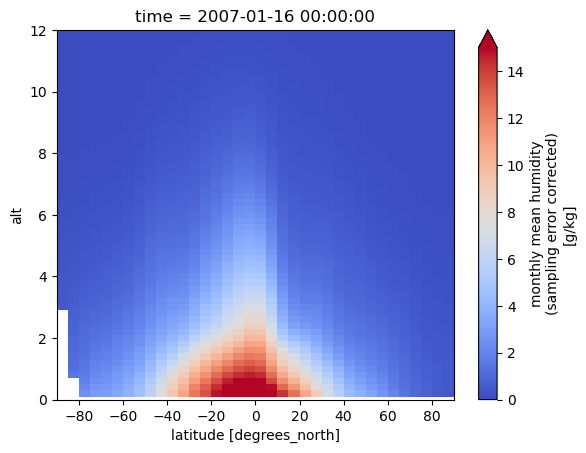

In [10]:
# January 2007
plot_date = "2007-01"
print(f'\n Selected date: {plot_date}')

da_mean.sel(time=plot_date).plot(xlim=[-90.0, 90.0], ylim=[0.0, 12.0], vmin=0.0, vmax=15.0,
                          extend='max', cmap='coolwarm')  # 'RdBu_r', 'coolwarm'
# Arguments controlling figure size and color map: figsize=(8,6), cmap='RdBu_r'

An alternative to the built-in Xarray plotting functions is to use [Matplotlib](https://matplotlib.org/) plotting tools that operate on Numpy arrays. Here, we repeat the monthly mean humidity plot using Matplotlib. The _contourf_ function gives a less "noisy" plot than _pcolormesh_, and has access to more plot options, but may require some experimentation. It is also possible to save the plot as a png file.

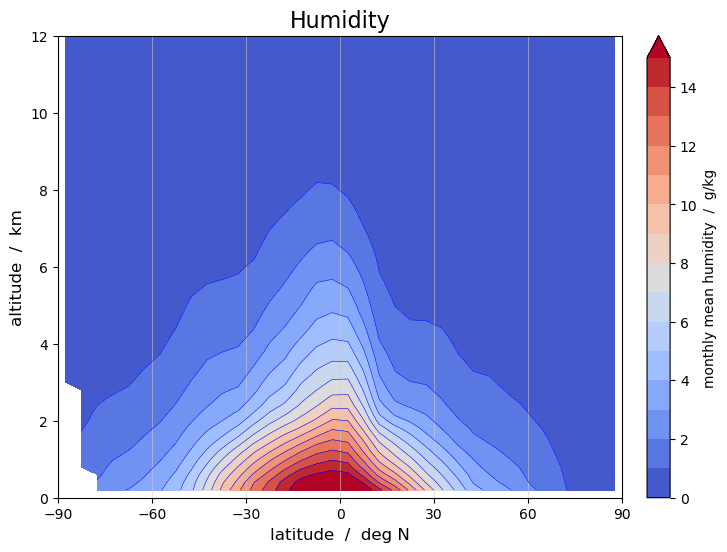

In [11]:
# Create the figure panel
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Plot the data with pcolormesh
# im = plt.pcolormesh(X, Y, Z[imon,:,:,0], vmin=0.0, vmax=15.0, cmap='coolwarm')   # 'RdBu_r'

# ... or plot with contour/contourf, manually defining the set of contours
clevels = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0]
im = plt.contour(
    da_mean.lat, da_mean.alt, da_mean.sel(time=plot_date).squeeze(),
    levels=clevels, linewidths=0.4, colors='b'
)
im = plt.contourf(
    da_mean.lat, da_mean.alt, da_mean.sel(time=plot_date).squeeze(),
    levels=clevels, vmin=0.0, vmax=15.0, extend='max', cmap='coolwarm'
)   # 'RdBu_r', 'RdYlBu_r', 'BuRd'

# Set figure title, axes ticks and labels, grid, etc.
ax.set_title('Humidity', fontsize=16)
ax.set_xlabel('latitude  /  deg N', fontsize=12)
ax.set_ylabel('altitude  /  km', fontsize=12)
ax.set_xlim(xmin=-90.0, xmax=90.0)
ax.set_ylim(ymin=0.0, ymax=12.0)
ax.xaxis.set_ticks([-90, -60, -30, 0, 30, 60, 90])
ax.xaxis.grid(True, linewidth=0.4, linestyle='-', color='0.8')

# Specify the colorbar
cbar = fig.colorbar(im, fraction=0.05, pad=0.04)
cbar.set_label('monthly mean humidity  /  g/kg')

# Save the figure as a png file
# fig.savefig(f'{DATADIR}hum_mon_lagrid_metop.png')

We find that the humidity has a peak in the lower troposphere near the equator. As we will se below (Use case 3) this peak moves seasonally back and forth in the north-south direction, as the Inter-Tropical Convergence Zone (ITCZ) moves through the seasons. We will also see (Use case 4) that the ENSO phenomenon in the Pacific has a dominating impact on the global humidity.

#### 4.1.2 Monthly standard deviation

Similarly, we can plot the monthly standard deviation as measure of the variability of the humidity within a month:

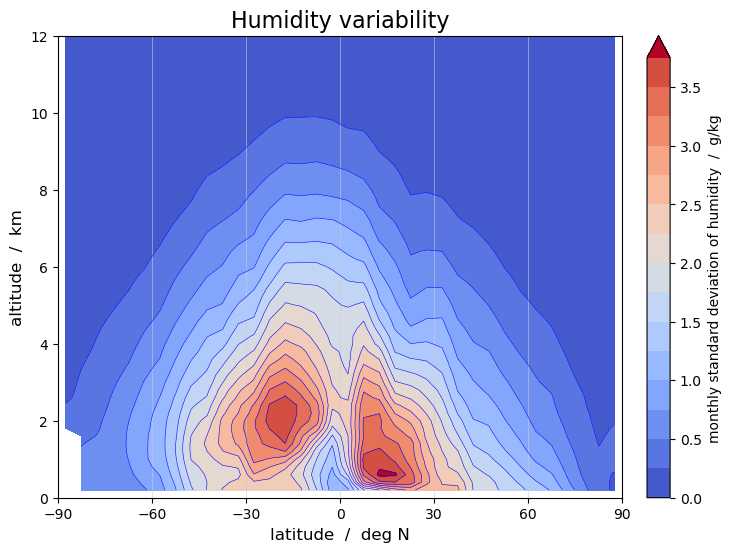

In [12]:
# Create the figure panel
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Plot the data with pcolormesh
# im = plt.pcolormesh(X, Y, Z[imon,:,:,0], vmin=0.0, vmax=4.0, cmap='coolwarm')   # 'RdBu_r'

# ... or plot with contour/contourf
im = plt.contour(
    da_stdev.lat, da_stdev.alt, da_stdev.sel(time=plot_date).squeeze(),
    levels=15, linewidths=0.4, colors='b'
)
im = plt.contourf(
    da_stdev.lat, da_stdev.alt, da_stdev.sel(time=plot_date).squeeze(),
    levels=15, vmin=0.0, vmax=4.0, extend='max', cmap='coolwarm'
)   # 'RdBu_r'

# Set figure title, axes ticks and labels, grid, etc.
ax.set_title('Humidity variability', fontsize=16)
ax.set_xlabel('latitude  /  deg N', fontsize=12)
ax.set_ylabel('altitude  /  km', fontsize=12)
ax.set_xlim(xmin=-90.0, xmax=90.0)
ax.set_ylim(ymin=0.0, ymax=12.0)
ax.xaxis.set_ticks([-90, -60, -30, 0, 30, 60, 90])
ax.xaxis.grid(True, linewidth=0.4, linestyle='-', color='0.8')

# Specify the colorbar
cbar = plt.colorbar(im, fraction=0.05, pad=0.04)
cbar.set_label('monthly standard deviation of humidity  /  g/kg')

# Save the figure
# fig.savefig(f'{DATADIR}hum_mon_lagrid_metop.png')

The zonal standard deviation plot has a pronounced two-peaked structure. This is largely a consequence of the fact that the standard deviation in a zonal grid not only measures the variability in time, but also the variability in longitude. Near the edge of the ITCZ, between say 15-25 degrees latitude, we find regions that are dry as well as regions that are humid at the same latitude, while nearer the equator humid conditions prevail at almost all longitudes. Just like the humidity distribution, the variability distribution moves seasonally back and forth over the equator as the ITCZ moves.


### 4.2 Use case 2: Climate normal and anomalies

#### 4.2.1 WMO standard reference periods

The World Meteorological Organization (WMO) defines standard reference periods for which climate normals are computed. Since 2021, the WMO recommends basing climate normals on the 1991-2020 reference period, replacing the previously used time period 1981-2010. 

Climate normals can be considered as the typical climate for the period the normals are based on. It is important that the reference periods are long enough that year-to-year variations are reasonably averaged out in the computed normals.

#### 4.2.2 Climate normals for a reference period

Many observational data records are not available for the full 30-year reference period recommended by the WMO. We have to work with shorter reference periods, limited by the availability of data.

To compute a climate normal we first define a certain reference period, and limit the data arrays to that period:

In [13]:
# Select a reference time period. Whole years.
year_ref_from = 2007
year_ref_to   = 2022

Ntime_ref = 12*(year_ref_to - year_ref_from + 1)

# Select data from the reference period (for computing the normals)
da_mean_ref = da_mean.where((da_year >= year_ref_from) & (da_year <= year_ref_to), drop=True)

We then compute two types of normal: a) the long-term climatological mean and b) the mean annual cycle (i.e., the climatologies for the particular months). For the latter, we use the Xarray method `groupby()` to group the data by month.

In [14]:
# Normals: long-term mean and mean seasonal cycle over the reference period
da_longnorm = da_mean_ref.mean(dim='time', skipna=True, keep_attrs=True)
da_seasnorm = da_mean_ref.groupby('time.month').mean(skipna=True, keep_attrs=True)

Plot the long-term climatological mean (using the built-in Xarray plot tool).

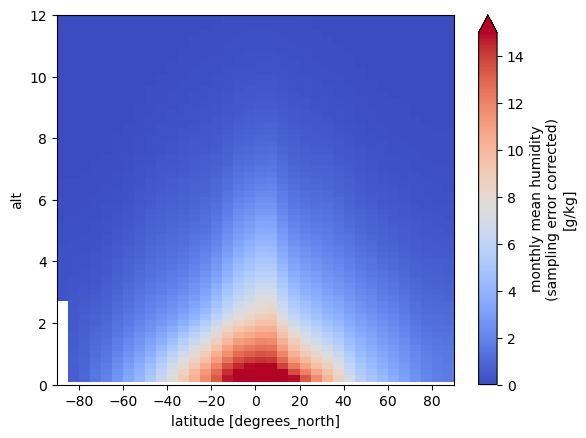

In [15]:
da_longnorm.plot(xlim=[-90.0, 90.0], ylim=[0.0,12.0], vmin=0.0, vmax=15.0, extend='max', cmap='coolwarm')

Plot the 12 monthly climatological means, representing the mean annual cycle.

Text(0.5, 1.02, 'Humidity mean annual cycle')

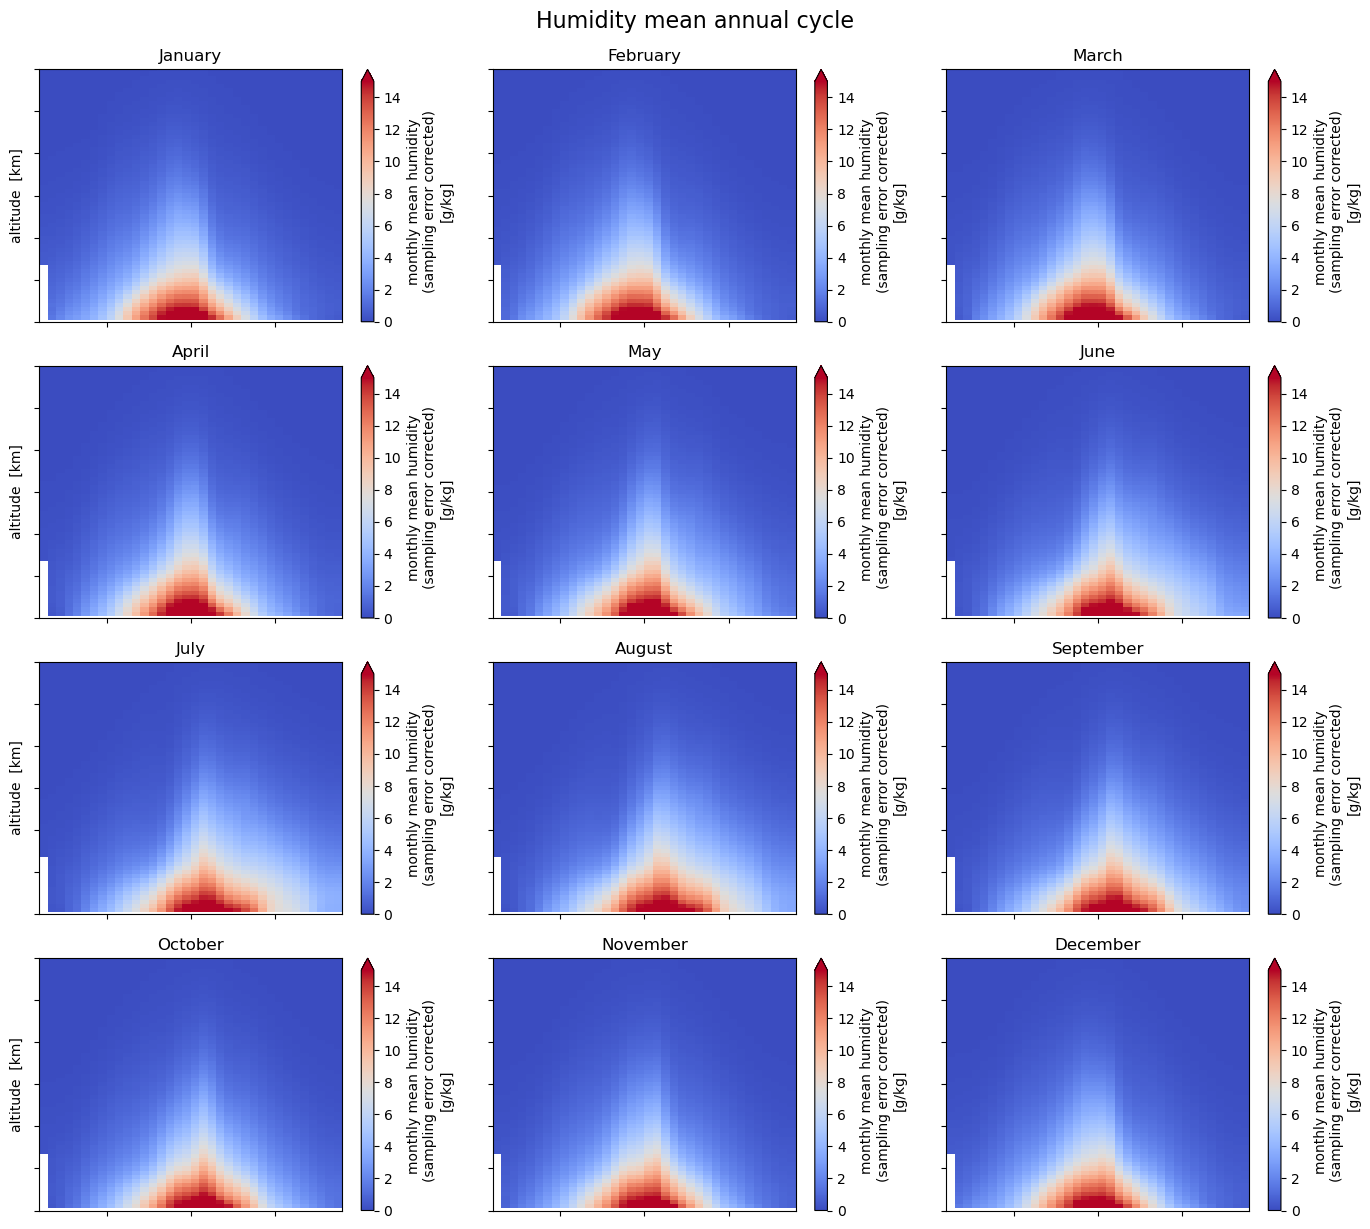

In [16]:
monstrng = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
            'August', 'September', 'October', 'November', 'December']

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14, 12))

for irow in range(4):
    da_seasnorm.sel(month=3*irow+1).plot(
        ax=axes[irow, 0], ylim=[0.0, 12.0], cmap="coolwarm", add_colorbar=True, vmin=0.0, vmax=15.0, extend="max")

    da_seasnorm.sel(month=3*irow+2).plot(
        ax=axes[irow, 1], ylim=[0.0, 12.0], cmap="coolwarm", add_colorbar=True, vmin=0.0, vmax=15.0, extend="max")

    da_seasnorm.sel(month=3*irow+3).plot(
        ax=axes[irow, 2], ylim=[0.0, 12.0], cmap="coolwarm", add_colorbar=True, vmin=0.0, vmax=15.0, extend="max")

    axes[irow, 0].set_title(monstrng[3*irow+0])
    axes[irow, 1].set_title(monstrng[3*irow+1])
    axes[irow, 2].set_title(monstrng[3*irow+2])

    axes[irow, 0].set_ylabel("altitude  [km]")
    axes[irow, 1].set_ylabel("")
    axes[irow, 2].set_ylabel("")

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.set_xlabel("")

plt.tight_layout()

fig.suptitle("Humidity mean annual cycle", fontsize=16, y=1.02)


#### 4.2.3 Anomalies with respect to a normal

With the normals thus defined, we can compute the anomalies with respect to the long-term climatological means as well as the anomalies with respect to the mean annual cycle. It is commonly the latter that is loosely referred to as "anomalies". Alternatively, we can express the anomalies in fractional terms, as the difference in percent relative to the normal.

In [17]:
# Anomalies: relative to long-term mean and relative to mean seasonal cycle
da_amean    = da_mean - da_longnorm
da_desamean = da_mean.groupby('time.month') - da_seasnorm

# Fractional anomalies
da_famean    = 100.0 * (da_amean / da_longnorm)
da_desfamean = 100.0 * (da_desamean.groupby('time.month') / da_seasnorm)


The last data array ('da_desfamean') contains the fractional anomalies with respect to the mean seasonal cycle, or 'de-seasonalized' anomalies. Let us now plot these anomalies for a full year:

Text(0.48, 1.02, 'Humidity anomalies during 2007')

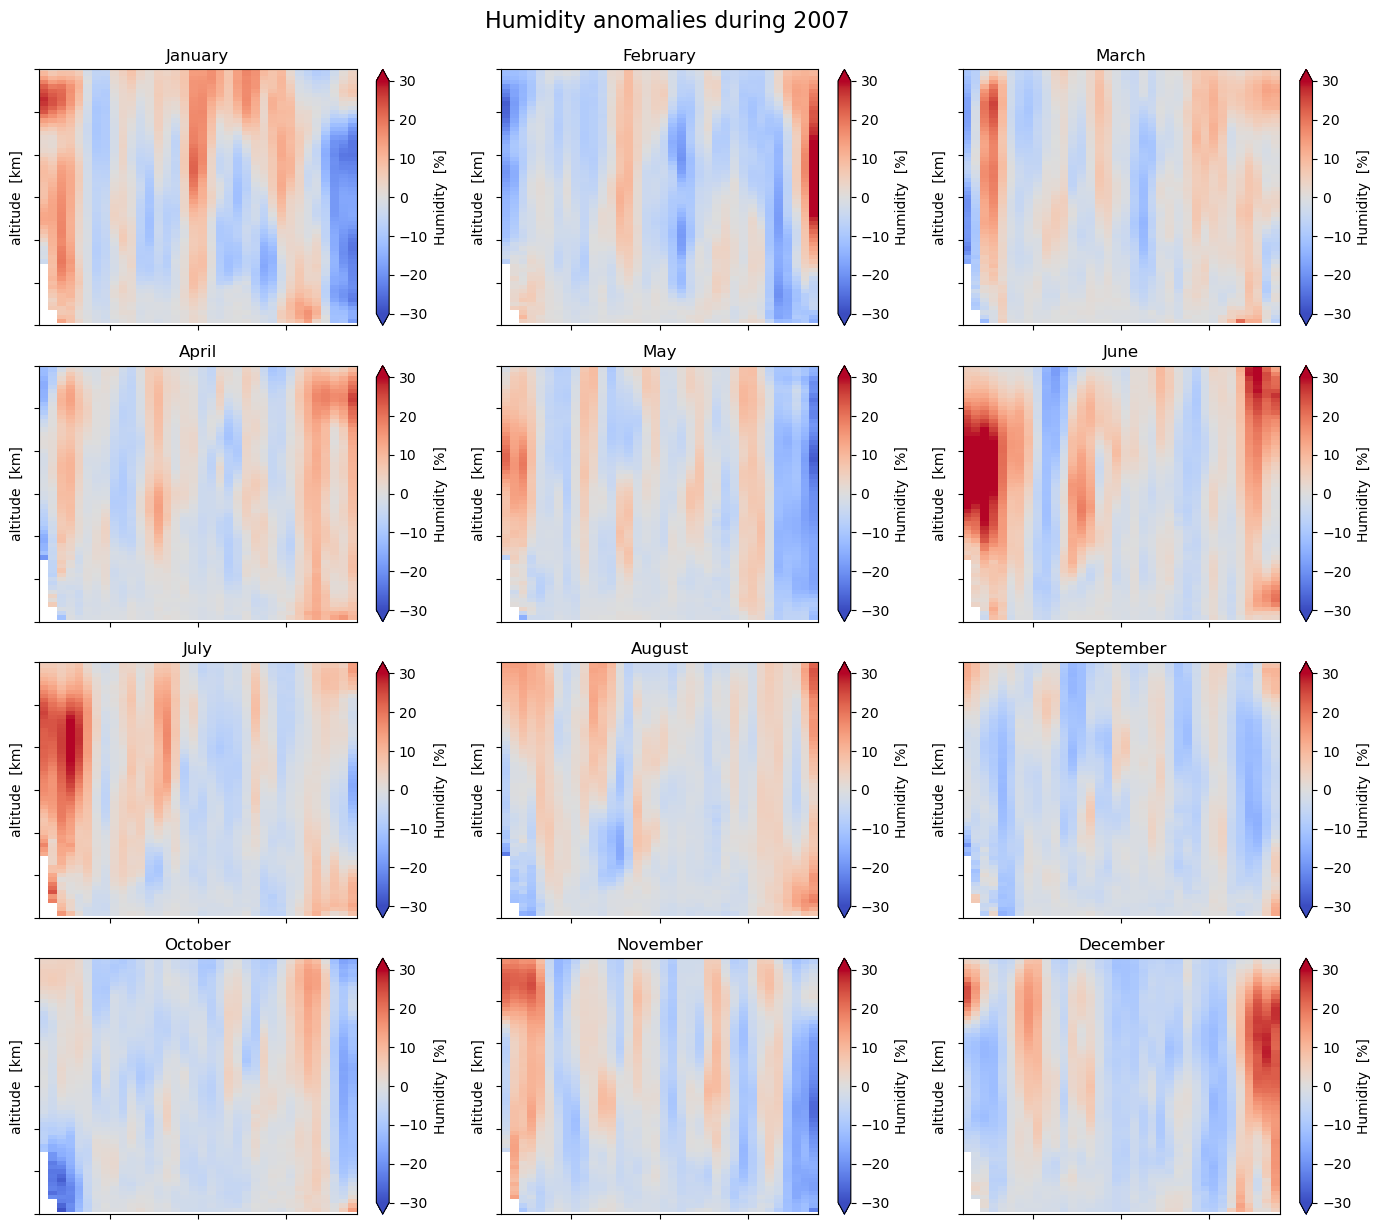

In [18]:
pltyear = 2007

itime0 = 12*(pltyear - year_ref_from)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14, 12))

for irow in range(4):
    for icol in range(3):
        da_desfamean[itime0+3*irow+icol, :, :].plot(
            ax=axes[irow, icol], ylim=[0.0, 12.0],
            vmin=-30.0, vmax=30.0, cmap="coolwarm",
            add_colorbar=True, extend="both", cbar_kwargs={'label': "Humidity  [%]"})
        axes[irow, icol].set_title(monstrng[3*irow+icol])
        axes[irow, icol].set_ylabel("altitude  [km]")

for icol in range(3):
    axes[3, icol].set_xlabel("latitude  [deg N]")

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.set_xlabel("")

plt.tight_layout()

fig.suptitle("Humidity anomalies during "+str(pltyear), fontsize=16, x=0.48, y=1.02)

It is emphasized that the percentages in the anomaly plots are the deviations of the specific humidity from the selected normal. It has nothing to do with relative humidity.

We find that the anomalies are mostly within about 10-15% of the normal seasonal cycle, occasionally and regionally extending to 20-30% or more. Some years (e.g., 2008) are globally drier and some years (e.g., 2016) are more humid. An important factor for the global humidity is the equatorial Pacific with the El Niño Southern Oscillation (ENSO) cycles, which is further explored in Use case 4 below. 

You can change normal, from mean seasonal cycle to long-term climatology by using the variable 'da_famean' instead of 'da_desfamean'. You may also need to change the span of the colorbar from 30% to 100% to accommodate the larger deviations from the normal. Doing this for any year reveal the strong seasonal cycle of the specific humidity, where the change of sign of the anomaly in a hemisphere occurs in May and November. The seasonal variations of the humidity is further explored in Use case 3 below.



### 4.3 Use case 3: Seasonal variations of tropospheric humidity

We will now take a closer look at the seasonal humidity variations; first height-resolved and then vertically averaged over atmospheric layers.

#### 4.3.1 Averaging humidity in latitude zones
The data are already averaged over longitude and within 5-degree latitude bands. The averaging has been done at fixed altitudes. Let us now average in six larger latitude zones, including globally, but still keep the data height resolved.

In [19]:
# Dictionary defining the latitude zones
latzones = {
    '90°S-60°S': [0,  0,  6],  # [-90,-60],
    '60°S-30°S': [1,  6, 12],  # [-60,-30],
    '30°S-30°N': [2, 12, 24],  # [-30, 30],
    '30°N-60°N': [3, 24, 30],  # [ 30, 60],
    '60°N-90°N': [4, 30, 36],  # [ 60, 90],
    '90°S-90°N': [5,  0, 36]}  # [-90, 90]}

# Define a new data array to hold the latitude zone averages (Ntime x Nalt x Nlatzone)
da_mean_latzone = da_mean[:, :, 0:6].copy().rename({'lat':'latzone'})

# Define a new data array to hold the cos-lat-weighted humidity data (Ntime x Nalt x Nlat)
da_mean_weighted = da_mean.copy()

# Compute averages in five latitude zones and globally
latweight = np.cos(np.deg2rad(da_mean.lat[:])).rename('latweight')
latweight = latweight.expand_dims(dim={"time":Ntime, "alt":Nalt})   # broadcast the 1D latweight array
latweight_masked = latweight.where(da_mean.notnull())               # set weights to NaN where da_mean is NaN
for izon in latzones:
    i = latzones[izon][0]   # latzone
    k = latzones[izon][1]   # from lat
    n = latzones[izon][2]   # to lat
    da_mean_weighted[:, :, k:n] = da_mean[:, :, k:n] * latweight_masked[:, :, k:n] / \
                                  latweight_masked[:, :, k:n].sum(dim='lat', skipna=True)
    da_mean_latzone[:, :, i] = da_mean_weighted[:, :, k:n].mean(dim='lat', skipna=True)

The Xarray object 'da_mean_latzone' contains monthly mean humidity in six wide latitude zones instead of the 5-degree latitude bands. Following the example in Use case 2 above, we now compute the anomalies of that data.

In [20]:
# Select a reference time period. Whole years.
year_ref_from = 2007
year_ref_to   = 2022

Ntime_ref = 12*(year_ref_to - year_ref_from + 1)

# Select data from the reference period (for computing the normals)
da_mean_latzone_ref = da_mean_latzone.where((da_year >= year_ref_from) &
                                            (da_year <= year_ref_to), drop=True)

# Normals: long-term mean and mean seasonal cycle over the reference period
da_longnorm = da_mean_latzone_ref.mean(dim='time', skipna=True, keep_attrs=True)
da_seasnorm = da_mean_latzone_ref.groupby('time.month').mean(skipna=True, keep_attrs=True)

# Anomalies relative to a) long-term mean and b) mean seasonal cycle
da_amean_latzone    = da_mean_latzone - da_longnorm
da_desamean_latzone = da_mean_latzone.groupby('time.month') - da_seasnorm

# Fractional anomalies
da_famean_latzone    = 100.0 * (da_amean_latzone / da_longnorm)
da_desfamean_latzone = 100.0 * (da_desamean_latzone.groupby('time.month') / da_seasnorm)


#### 4.3.2 Seasonal cycles in height-resolved data

We can now plot the height-resolved anomalies as time series. Let us do this for the fractional anomalies (anomalies expressed in percent) in three latitude zones: northern mid-latitudes, low latitudes, and southern mid-latitudes.

Text(0.5, 0, '')

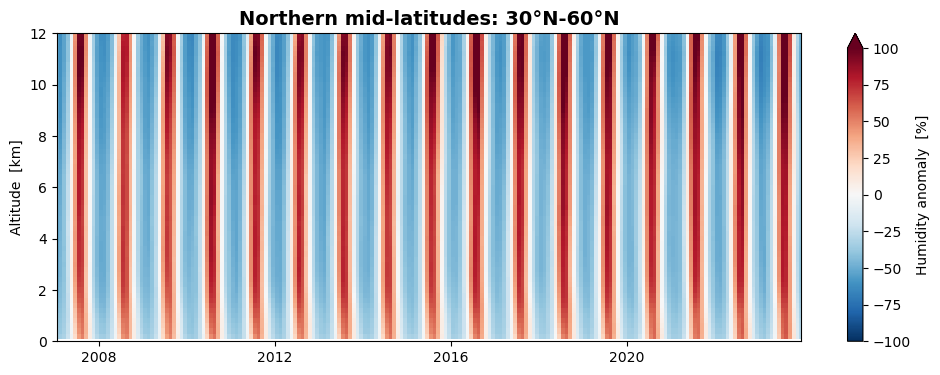

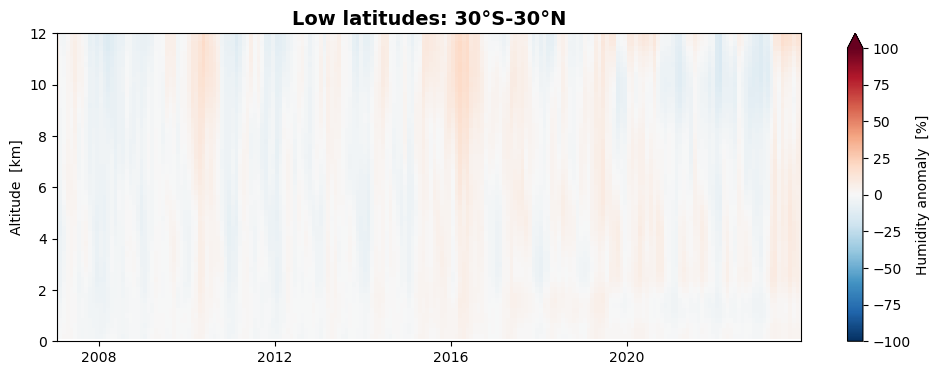

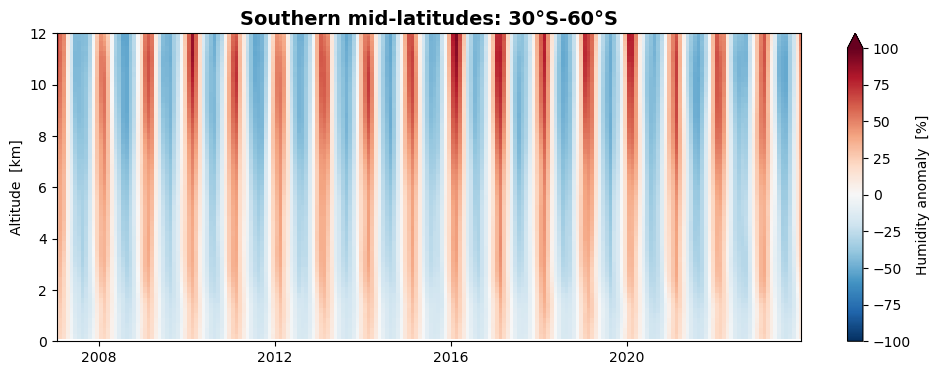

In [21]:
# Start/end times as instances of cftime
date_from = cftime.datetime(year=da_year[0], month=da_month[0],  day=16)
date_to   = cftime.datetime(year=da_year[Ntime-1], month=da_month[Ntime-1], day=16)

# Northern mid-latitudes (30°N-60°N)
izon = 3
da_famean_latzone[:, :, izon].plot(figsize=(12,4), x='time', y='alt',
                                   xlim=[date_from, date_to], ylim=[0.0, 12.0],
                                   vmin=-100.0, vmax=100.0, extend='max', cmap='RdBu_r',
                                   cbar_kwargs={'label': "Humidity anomaly  [%]"})
plt.title('Northern mid-latitudes: 30°N-60°N', fontsize=14, fontweight='bold')
plt.ylabel('Altitude  [km]')
plt.xlabel('')

# Low latitudes (30°S-30°N)
izon = 2
da_famean_latzone[:, :, izon].plot(figsize=(12,4), x='time', y='alt',
                                   xlim=[date_from, date_to], ylim=[0.0, 12.0],
                                   vmin=-100.0, vmax=100.0, extend='max', cmap='RdBu_r',
                                   cbar_kwargs={'label': "Humidity anomaly  [%]"})
plt.title('Low latitudes: 30°S-30°N', fontsize=14, fontweight='bold')
plt.ylabel('Altitude  [km]')
plt.xlabel('')

# Southern mid-latitudes (30°S-60°S)
izon = 1
da_famean_latzone[:, :, izon].plot(figsize=(12,4), x='time', y='alt',
                                   xlim=[date_from, date_to], ylim=[0.0, 12.0],
                                   vmin=-100.0, vmax=100.0, extend='max', cmap='RdBu_r',
                                   cbar_kwargs={'label': "Humidity anomaly  [%]"})
plt.title('Southern mid-latitudes: 30°S-60°S', fontsize=14, fontweight='bold')
plt.ylabel('Altitude  [km]')
plt.xlabel('')


We find that the seasonal variation of humidity is stronger at northern mid-latitudes than at southern mid-latitudes, while they are almost absent at low latitudes.


#### 4.3.3 Averaging humidity anomalies in vertical layers

Specific humidity normally falls off rapidly with height. This is also the case for anomalies, while the fractional anomalies do not exhibit any underlying strong height dependence. We will now average the fractional anomalies in 4 kilometer thick vertical layers (0-4 km, 4-8 km, and 8-12 km) allowing us to do line plotting. 

In [22]:
# Dictionary defining the vertical layers
layers = {
    '0-4km' : [0,  0, 20],   # {'bounds': [0,4000],     'colour': '#ca313e'},
    '4-8km' : [1, 20, 40],   # {'bounds': [4000,8000],  'colour': '#eace24'},
    '8-12km': [2, 40, 60]}   # {'bounds': [8000,12000], 'colour': '#428ed0'}}

# Define a new data array to hold the layer averages of anomalies
da_famean_latzone_layer = da_famean_latzone[:, 0:3, :].copy().rename({'alt':'layer'})

# Define a new Xarray data array to hold the layer averages of deseasonalized anomalies
da_desfamean_latzone_layer = da_desfamean_latzone[:, 0:3, :].copy().rename({'alt':'layer'})

# Compute averages in three vertical layers
for ilay in layers:
    i = layers[ilay][0]
    k = layers[ilay][1]
    n = layers[ilay][2]
    da_famean_latzone_layer[:, i, :]    = da_famean_latzone[:, k:n, :].mean(dim='alt', skipna=True)
    da_desfamean_latzone_layer[:, i, :] = da_desfamean_latzone[:, k:n, :].mean(dim='alt', skipna=True)

#### 4.3.4 Seasonal cycles in height layers

We can now plot the vertically averaged fractional anomalies as time series. Let us again do this for three latitude zones: northern mid-latitudes, low latitudes, and southern mid-latitudes.


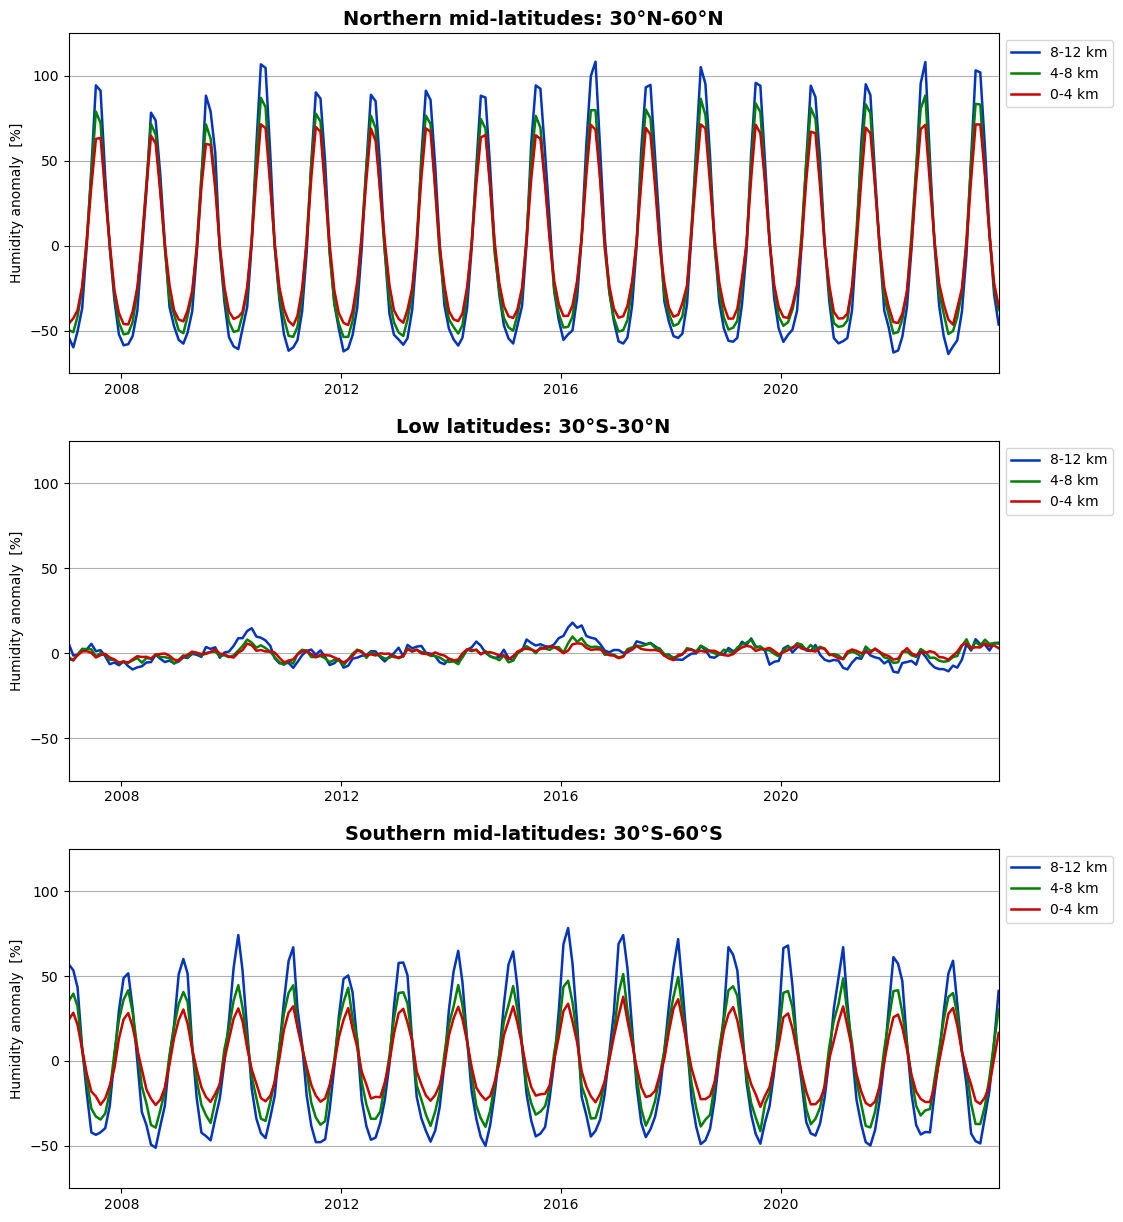

In [23]:
# Start/end times as instances of cftime
date_from = cftime.datetime(year=da_year[0], month=da_month[0],  day=16)
date_to   = cftime.datetime(year=da_year[Ntime-1], month=da_month[Ntime-1], day=16)

# Vertically averaged global-mean humidity anomalies, flip to get the 8-12 km layer first
izon = 3   # 30°N-60°N
da_hum_nmid = da_famean_latzone_layer[:, :, izon].squeeze()
da_hum_nmid = np.flip(da_hum_nmid)
izon = 2   # 30°S-30°N
da_hum_low = da_famean_latzone_layer[:, :, izon].squeeze()
da_hum_low = np.flip(da_hum_low)
izon = 1   # 30°S-60°S
da_hum_smid = da_famean_latzone_layer[:, :, izon].squeeze()
da_hum_smid = np.flip(da_hum_smid)

# Define figure
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

# Plot humidity, 30°N-60°N
ax1.set_prop_cycle(color=['#0334BB', 'green', '#CC0000'])
da_hum_nmid[:, 0:3].plot.line(ax=ax1, x='time', xlim=[date_from, date_to], ylim=[-75.0, 125.0],
                              yticks=[-50, 0, 50, 100], linewidth=1.8, add_legend=True)
ax1.legend(['8-12 km', '4-8 km', '0-4 km'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
ax1.set_title('Northern mid-latitudes: 30°N-60°N', fontsize=14, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('Humidity anomaly  [%]')
ax1.grid(which='major', axis='y')

# Plot humidity, 30°S-30°N
ax2.set_prop_cycle(color=['#0334BB', 'green', '#CC0000'])
da_hum_low[:, 0:3].plot.line(ax=ax2, x='time', xlim=[date_from, date_to], ylim=[-75.0, 125.0],
                             yticks=[-50, 0, 50, 100], linewidth=1.8, add_legend=True)
ax2.legend(['8-12 km', '4-8 km', '0-4 km'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
ax2.set_title('Low latitudes: 30°S-30°N', fontsize=14, fontweight='bold')
ax2.set_xlabel('')
ax2.set_ylabel('Humidity anomaly  [%]')
ax2.grid(which='major', axis='y')

# Plot humidity, 30°S-60°S
ax3.set_prop_cycle(color=['#0334BB', 'green', '#CC0000'])
da_hum_smid[:, 0:3].plot.line(ax=ax3, x='time', xlim=[date_from, date_to], ylim=[-75.0, 125.0],
                              yticks=[-50, 0, 50, 100], linewidth=1.8, add_legend=True)
ax3.legend(['8-12 km', '4-8 km', '0-4 km'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
ax3.set_title('Southern mid-latitudes: 30°S-60°S', fontsize=14, fontweight='bold')
ax3.set_xlabel('')
ax3.set_ylabel('Humidity anomaly  [%]')
ax3.grid(which='major', axis='y')

The same picture emerges: the seasonal variation of humidity is stronger in the northern hemisphere than in the southern hemisphere, while they are almost absent at low latitudes.

Let us now look at the global variation with season:

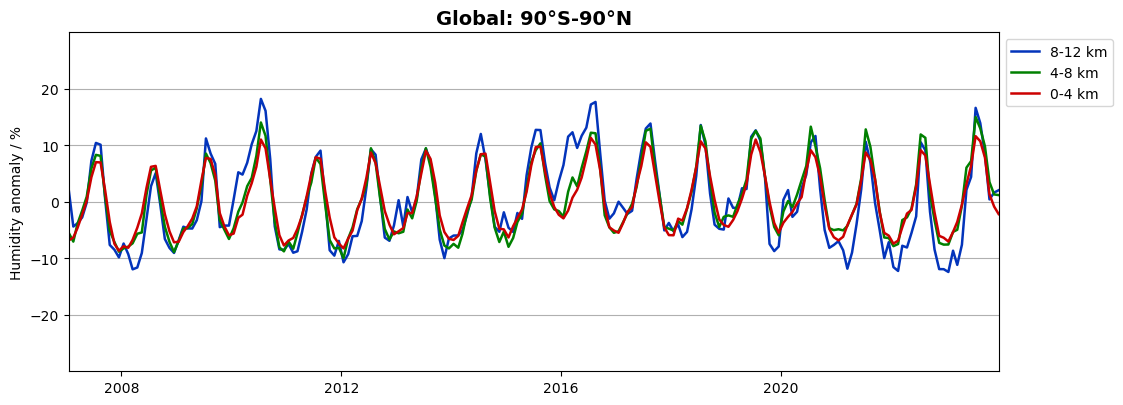

In [24]:
# Select global means (90°S-90°N)
izon = 5

# Vertically averaged global-mean humidity anomalies, flip to get the 8-12 km layer first
da_hum = da_famean_latzone_layer[:, :, izon].squeeze()
da_hum = np.flip(da_hum, 1)

# Define figure
fig, ax = plt.subplots(1, 1, figsize=(12, 4.4))

# Plot humidity
ax.set_prop_cycle(color=['#0334BB', 'green', '#CC0000'])
da_hum[:, 0:3].plot.line(ax=ax, x='time', xlim=[date_from, date_to], ylim=[-30.0, 30.0],
                         yticks=[-20, -10, 0, 10, 20], linewidth=1.8, add_legend=True)
plt.legend(['8-12 km', '4-8 km', '0-4 km'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.title('Global: 90°S-90°N', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('Humidity anomaly / %')
plt.grid(which='major', axis='y')


We find a seasonal variation also in global data, dominated by the northern hemisphere seasons. Let us now see which humidity variations that remain if we plot the de-seasonalized anomalies:

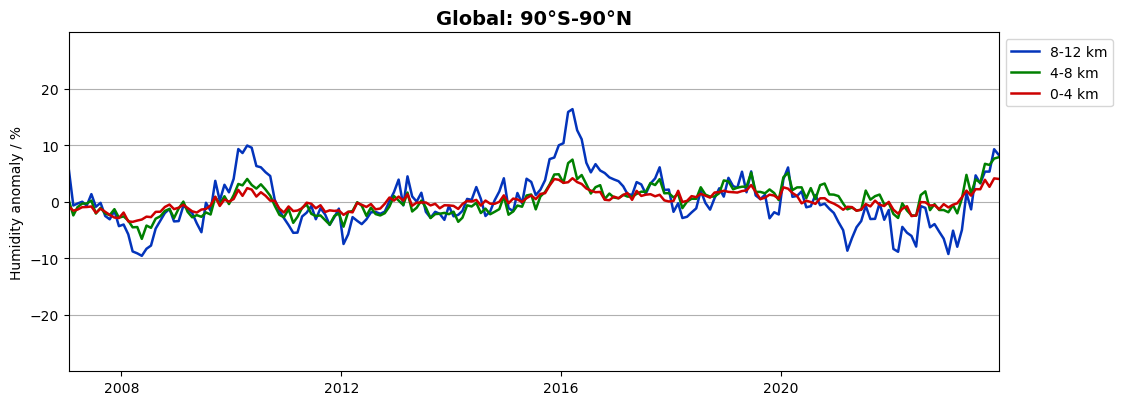

In [25]:
# Select global means (90°S-90°N)
izon = 5

# Vertically averaged global-mean humidity anomalies, flip to get the 8-12 km layer first
da_hum = da_desfamean_latzone_layer[:, :, izon].squeeze()
da_hum = np.flip(da_hum, 1)

# Define figure
fig, ax = plt.subplots(1, 1, figsize=(12, 4.4))

# Plot humidity
ax.set_prop_cycle(color=['#0334BB', 'green', '#CC0000'])
da_hum[:, 0:3].plot.line(ax=ax, x='time', xlim=[date_from, date_to], ylim=[-30.0, 30.0],
                         yticks=[-20, -10, 0, 10, 20], linewidth=1.8, add_legend=True)
plt.legend(['8-12 km', '4-8 km', '0-4 km'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.title('Global: 90°S-90°N', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('Humidity anomaly / %')
plt.grid(which='major', axis='y')

We find a semi-annual variation in global humidity on the order of 5-10% on top of the mean seasonal variation. Several minima and maxima can be identified which coincide with different phases of the El Niño Southern Oscillation (ENSO) cycles. This is further explored in Use case 4 below.

### 4.4 Use case 4:  Global humidity and the El Niño Southern Oscillation

To proceed with this Use case you first need to go through Use case 3, as those time series are used here.

The El Niño-Southern Oscillation (ENSO) is a recurring phenomenon in the central and eastern tropical Pacific Ocean. On periods ranging from about three to seven years, the surface waters across a large swath of the tropical Pacific Ocean warm or cool by anywhere from 1°C to 3°C, compared to normal. The phase of the ENSO cycle is commonly quantified by indices describing the sea-surface temperatures (SSTs) in central parts of the Pacific, e.g., the NINO 3.4 index which can be thought of as the equatorial SSTs averaged from the dateline to the South American coast (5°S-5°N, 120°W-170°W).

The NINO 3.4 index is generated and distributed by NOAA's Climate Prediction Center (https://www.cpc.ncep.noaa.gov).
Let us download the file https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt, extract monthly data for the duration of the humidity time series, and store that data as a Numpy array. 

In [26]:
# Download the ENSO data file from NOAA's Climate Prediction Center
url = 'https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt'
ensofile = DATADIR + 'enso.dat'
urlretrieve(url, ensofile)

# List the seasons used in the ENSO data file
seastrng = ['DJF', 'JFM', 'FMA', 'MAJ', 'AMJ', 'MJJ',
            'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']

# Read data from the file
f = open(ensofile, 'r')
seas_enso = np.genfromtxt(f, dtype=str,   skip_header=1, usecols=(0))
f.seek(0)
year_enso = np.genfromtxt(f, dtype=int,   skip_header=1, usecols=(1))
f.seek(0)
data_enso = np.genfromtxt(f, dtype=float, skip_header=1, usecols=(2, 3))
f.close()

# Locate the month in the ENSO record that coincide with the start the humidity data record
i0 = -1
for i in range(len(year_enso)):
    if year_enso[i] == int(da_year[0]) and seas_enso[i] == seastrng[int(da_month[0])-1]:
        i0 = i

# The ENSO 3.4 index during the humidity data record
mean_enso = data_enso[i0:i0+Ntime, 0].squeeze()
anom_enso = data_enso[i0:i0+Ntime, 1].squeeze()

Select global mean humidity anomalies from Use case 3. Use the de-seasonalized anomalies of data vertically averaged in latitude zones:

In [27]:
# Select global means (90°S-90°N)
izon = 5

# Vertically averaged global-mean humidity anomalies, flip to get the 8-12 km layer first
da_hum = da_desfamean_latzone_layer[:, :, izon].squeeze()
da_hum = np.flip(da_hum, 1)

Let us now plot the ENSO data along with the global humidity anomalies.

Text(0.5, 1.0, 'ENSO index')

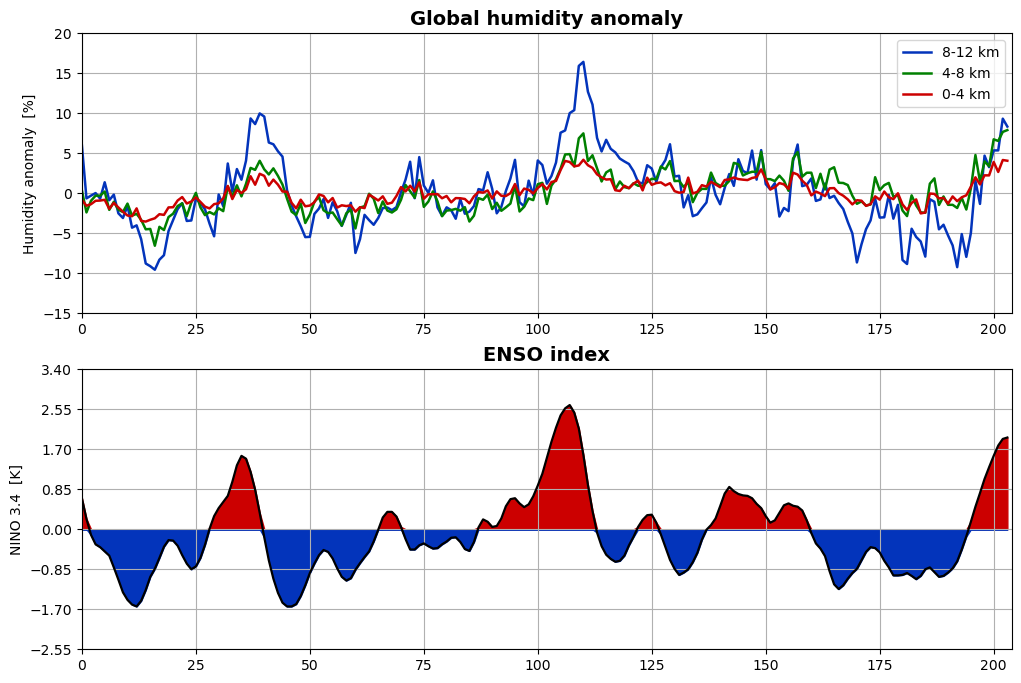

In [28]:
# Generate positive-only and negative-only ENSO time series
x = np.arange(Ntime)
yzero = np.zeros(Ntime)
ypos  = np.where(anom_enso >= 0.0, anom_enso, yzero)
yneg  = np.where(anom_enso < 0.0,  anom_enso, yzero)

# Define figure
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot global humidity
ax1.set_prop_cycle(color=['#0334BB', 'green', '#CC0000'])
ax1.plot(x, da_hum[:, 0:3], linewidth=1.8)
ax1.set_xlim(xmin=0, xmax=Ntime)
ax1.set_ylim(ymin=-15.0, ymax=20.0)
ax1.set_yticks([-15, -10, -5, 0, 5, 10, 15, 20])
ax1.grid(which='major')
ax1.legend(['8-12 km', '4-8 km', '0-4 km'])
ax1.set_ylabel('Humidity anomaly  [%]')
ax1.set_title('Global humidity anomaly', fontsize=14, fontweight='bold')

# Plot ENSO
ax2.plot(x, anom_enso, 'black', linewidth=1.6)
ax2.set_xlim(xmin=0, xmax=Ntime)
ax2.set_ylim(ymin=-2.55, ymax=3.4)
ax2.set_yticks([-2.55, -1.70, -0.85, 0.0, 0.85, 1.70, 2.55, 3.40])
ax2.grid(which='major')
ax2.fill_between(x, ypos, color='#CC0000')
ax2.fill_between(x, yneg, color='#0334BB')
ax2.set_ylabel('NINO 3.4  [K]')
ax2.set_title('ENSO index', fontsize=14, fontweight='bold')

# Save the figure
# fig.savefig(f'{DATADIR}ERA5_global_2016_anomaly_eur.png')

There is a close correspondence between the phase of ENSO and global humidity anomalies, where the humidity seems to lag ENSO by about 2-4 months. It appears that the ENSO is a major governing factor for global humidity. The details of the causality, e.g., which parts of the globe that contribute to this relation and what the relevant correlations and time lags are, is something that could be further studied with this and other humidity datasets.


## 5. References

Gleisner, H., K.B. Lauritsen, J.K. Nielsen, and S. Syndergaard, (2020): Evaluation of the 15-year ROM SAF monthly mean GPS radio occultation climate data record, Atmos. Meas. Tech., 13, 3081–3098, DOI: https://doi.org/10.5194/amt-13-3081-2020
